# Seattle Police Department Terry Stops 

## Build a classifier to predict whether an arrest was made after a Terry Stop, given information about the presence of weapons, the time of day of the call, etc. Note that this is a binary classification problem.

In [1]:
#Setting up environment with initial libraries needed for importing, cleaning, and initial visualization
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import sweetviz as sv

import cufflinks as cf
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 25)
pd.set_option('display.float_format', '{:,}'.format)

sns.set_style('darkgrid')

%matplotlib inline

C:\Users\jtang\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import Seattle Terry Stop dataset
terry_df = pd.read_csv('../data/Terry_Stops.csv')

# Verify dataset import and by calling first  five rows of data
terry_df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20150000002351,45252,Field Contact,None,7591,1985,M,Hispanic or Latino,Other,Female,2015-05-20T00:00:00,21:39:00,-,-,-,WEST PCT 3RD W - MARY,N,N,-,-,-
1,-,-1,20150000002363,45182,Field Contact,None,7591,1985,M,Hispanic or Latino,White,Male,2015-05-20T00:00:00,22:40:00,-,-,-,WEST PCT 3RD W - MARY,N,N,-,-,-
2,-,-1,20150000002392,45365,Field Contact,None,7560,1986,M,White,White,Female,2015-05-22T00:00:00,07:39:00,-,-,-,SOUTH PCT 1ST W - R/S RELIEF,N,N,East,E,E2
3,-,-1,20150000002451,46430,Field Contact,None,7591,1985,M,Hispanic or Latino,-,-,2015-05-25T00:00:00,01:06:00,-,-,-,WEST PCT 3RD W - MARY,N,N,-,-,-
4,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2


In [3]:
#call shape of dataframe
terry_df.shape

(46315, 23)

>46k rows x 23 columns

In [4]:
terry_df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

### [X] Remove spaces from column names

In [5]:
terry_df.columns = ['Subject_Age_Group', 'Subject_ID', 'GO_SC_Num', 'Terry_Stop_ID',
       'Stop_Resolution', 'Weapon_Type', 'Officer_ID', 'Officer_YOB',
       'Officer_Gender', 'Officer_Race', 'Subject_Perceived_Race',
       'Subject_Perceived_Gender', 'Reported_Date', 'Reported_Time',
       'Initial_Call_Type', 'Final_Call_Type', 'Call_Type', 'Officer_Squad',
       'Arrest_Flag', 'Frisk_Flag', 'Precinct', 'Sector', 'Beat']

In [6]:
terry_df.columns

Index(['Subject_Age_Group', 'Subject_ID', 'GO_SC_Num', 'Terry_Stop_ID',
       'Stop_Resolution', 'Weapon_Type', 'Officer_ID', 'Officer_YOB',
       'Officer_Gender', 'Officer_Race', 'Subject_Perceived_Race',
       'Subject_Perceived_Gender', 'Reported_Date', 'Reported_Time',
       'Initial_Call_Type', 'Final_Call_Type', 'Call_Type', 'Officer_Squad',
       'Arrest_Flag', 'Frisk_Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

In [7]:
terry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46315 entries, 0 to 46314
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject_Age_Group         46315 non-null  object
 1   Subject_ID                46315 non-null  int64 
 2   GO_SC_Num                 46315 non-null  int64 
 3   Terry_Stop_ID             46315 non-null  int64 
 4   Stop_Resolution           46315 non-null  object
 5   Weapon_Type               46315 non-null  object
 6   Officer_ID                46315 non-null  object
 7   Officer_YOB               46315 non-null  int64 
 8   Officer_Gender            46315 non-null  object
 9   Officer_Race              46315 non-null  object
 10  Subject_Perceived_Race    46315 non-null  object
 11  Subject_Perceived_Gender  46315 non-null  object
 12  Reported_Date             46315 non-null  object
 13  Reported_Time             46315 non-null  object
 14  Initial_Call_Type     

In [8]:
terry_df.isnull().any()

Subject_Age_Group           False
Subject_ID                  False
GO_SC_Num                   False
Terry_Stop_ID               False
Stop_Resolution             False
Weapon_Type                 False
Officer_ID                  False
Officer_YOB                 False
Officer_Gender              False
Officer_Race                False
Subject_Perceived_Race      False
Subject_Perceived_Gender    False
Reported_Date               False
Reported_Time               False
Initial_Call_Type           False
Final_Call_Type             False
Call_Type                   False
Officer_Squad                True
Arrest_Flag                 False
Frisk_Flag                  False
Precinct                    False
Sector                      False
Beat                        False
dtype: bool

In [9]:
#confirming missing values
for col in terry_df:
    mv = terry_df[col].isna().sum()
    if mv > 0:
        print(f'{col} column has {mv} missing values')

Officer_Squad column has 605 missing values


### [ ] Drop missing values in 'Officer Squad'

In [10]:
#checking for duplicate rows across all columns
duplicate_rows = terry_df[terry_df.duplicated()]
print(f"The are {len(duplicate_rows)} duplicate rows in the dataframe.")

The are 0 duplicate rows in the dataframe.


## Link to initial Pandas Profiling Report: [terry_initial.html](files/terry_initial.html)

In [11]:
terry_df['Subject_Age_Group'].unique()

array(['-', '1 - 17', '18 - 25', '26 - 35', '36 - 45', '46 - 55',
       '56 and Above'], dtype=object)

### [ ] process Subject_Age_Group values >> " - " 

<AxesSubplot:xlabel='count', ylabel='Subject_Age_Group'>

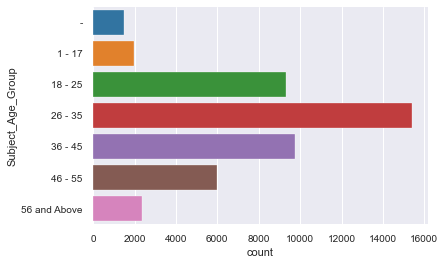

In [12]:
sns.countplot(y='Subject_Age_Group', data=terry_df )

In [13]:
for col in terry_df.columns:
    print(col)
    print(terry_df[col].unique())
    print('\n')

Subject_Age_Group
['-' '1 - 17' '18 - 25' '26 - 35' '36 - 45' '46 - 55' '56 and Above']


Subject_ID
[         -1  7726713382  7727213211 ... 20356430687 20370055391
 20414308762]


GO_SC_Num
[20150000002351 20150000002363 20150000002392 ... 20210000022390
 20210000027381 20210000033131]


Terry_Stop_ID
[      45252       45182       45365 ... 20356441466 20370213152
 20414094359]


Stop_Resolution
['Field Contact' 'Arrest' 'Citation / Infraction' 'Offense Report'
 'Referred for Prosecution']


Weapon_Type
['None' 'Firearm Other' 'Lethal Cutting Instrument' 'Handgun' '-'
 'Club, Blackjack, Brass Knuckles' 'Knife/Cutting/Stabbing Instrument'
 'Other Firearm' 'Rifle' 'Fire/Incendiary Device'
 'Blunt Object/Striking Implement' 'Firearm (unk type)'
 'Mace/Pepper Spray' 'None/Not Applicable' 'Club' 'Firearm'
 'Taser/Stun Gun' 'Shotgun' 'Brass Knuckles' 'Automatic Handgun'
 'Blackjack' 'Personal Weapons (hands, feet, etc.)']


Officer_ID
['7591  ' '7560  ' '7500  ' ... '8786  ' '6983  ' '591

<AxesSubplot:xlabel='count', ylabel='Weapon_Type'>

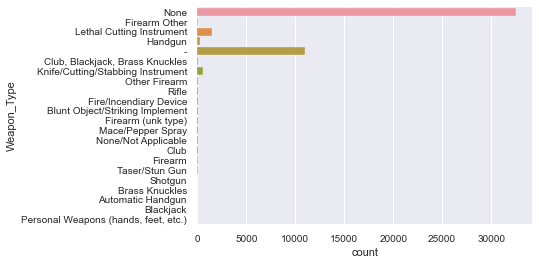

In [14]:
# looking at weapon values

sns.countplot(y='Weapon_Type', data=terry_df )

## Link to initial Sweet Viz report [terry_sweetviz_base.html](files/terry_sweetviz_base.html)

In [15]:
# finding "-" values in dataframe

terry_df[terry_df == '-'].any()

Subject_Age_Group            True
Subject_ID                  False
GO_SC_Num                   False
Terry_Stop_ID               False
Stop_Resolution             False
Weapon_Type                  True
Officer_ID                   True
Officer_YOB                 False
Officer_Gender              False
Officer_Race                False
Subject_Perceived_Race       True
Subject_Perceived_Gender     True
Reported_Date               False
Reported_Time               False
Initial_Call_Type            True
Final_Call_Type              True
Call_Type                    True
Officer_Squad               False
Arrest_Flag                 False
Frisk_Flag                   True
Precinct                     True
Sector                       True
Beat                         True
dtype: bool

In [16]:
terry_df[terry_df.eq("-").any(1)]

,Subject_Age_Group,Subject_ID,GO_SC_Num,Terry_Stop_ID,Stop_Resolution,Weapon_Type,Officer_ID,Officer_YOB,Officer_Gender,Officer_Race,Subject_Perceived_Race,Subject_Perceived_Gender,Reported_Date,Reported_Time,Initial_Call_Type,Final_Call_Type,Call_Type,Officer_Squad,Arrest_Flag,Frisk_Flag,Precinct,Sector,Beat
0,-,-1,20150000002351,45252,Field Contact,None,7591,1985,M,Hispanic or Latino,Other,Female,2015-05-20T00:00:00,21:39:00,-,-,-,WEST PCT 3RD W - MARY,N,N,-,-,-
1,-,-1,20150000002363,45182,Field Contact,None,7591,1985,M,Hispanic or Latino,White,Male,2015-05-20T00:00:00,22:40:00,-,-,-,WEST PCT 3RD W - MARY,N,N,-,-,-
2,-,-1,20150000002392,45365,Field Contact,None,7560,1986,M,White,White,Female,2015-05-22T00:00:00,07:39:00,-,-,-,SOUTH PCT 1ST W - R/S RELIEF,N,N,East,E,E2
3,-,-1,20150000002451,46430,Field Contact,None,7591,1985,M,Hispanic or Latino,-,-,2015-05-25T00:00:00,01:06:00,-,-,-,WEST PCT 3RD W - MARY,N,N,-,-,-
4,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46310,56 and Above,20160248170,20210000021921,20160361947,Arrest,-,8776,1992,M,Two or More Races,White,Male,2021-01-26T00:00:00,23:32:26,THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING),"--ASSAULTS - HARASSMENT, THREATS",911,TRAINING - FIELD TRAINING SQUAD,Y,Y,West,Q,Q3
46311,56 and Above,20171833316,20210000022390,20171881453,Offense Report,-,8770,1995,F,White,Unknown,Female,2021-01-27T00:00:00,13:47:49,ASLT - WITH OR W/O WEAPONS (NO SHOOTINGS),"--ASSAULTS, OTHER",911,TRAINING - FIELD TRAINING SQUAD,N,N,West,D,D3
46312,56 and Above,20356430687,20210000027381,20356441466,Field Contact,-,6123,1973,M,White,White,Female,2021-02-02T00:00:00,10:35:06,MVC - WITH INJURIES (INCLUDES HIT AND RUN),--TRAFFIC - MV COLLISION INVESTIGATION,911,TRAF - COLLISION INVESTIGATION,N,N,West,M,M2
46313,56 and Above,20370055391,20210000028500,20370213152,Field Contact,-,8689,1987,M,White,White,Female,2021-02-03T00:00:00,14:30:26,BURG - IP/JO - RES (INCL UNOCC STRUCTURES),--PROWLER - TRESPASS,911,WEST PCT 2ND W - KING,N,N,West,Q,Q2


In [23]:
#looking at arrests by group

terry_df.groupby(['Subject_Age_Group'])['Arrest_Flag'].count()

Subject_Age_Group
-                1500
1 - 17           1961
18 - 25          9336
26 - 35         15403
36 - 45          9775
46 - 55          5992
56 and Above     2348
Name: Arrest_Flag, dtype: int64

In [25]:
terry_df.groupby(['Stop_Resolution'])['Arrest_Flag'].count()

Stop_Resolution
Arrest                      11398
Citation / Infraction         177
Field Contact               18560
Offense Report              15452
Referred for Prosecution      728
Name: Arrest_Flag, dtype: int64

### [ ] Columns to look at for encoding

- Arrest_Flag *** binary, implicated in Stop_Resolution
- Officer_YOB *** change to age?

- Subject_Age_Group
- Stop_Resolution          
- Weapon_Type ***         
- Officer_ID                
- Officer_Gender            
- Officer_Race              
- Subject_Perceived_Race    
- Subject_Perceived_Gender  
- Reported_Date            
- Reported_Time             
- Initial_Call_Type         
- Final_Call_Type           
- Call_Type                 
- Officer_Squad             
- Frisk_Flag                
- Precinct                 
- Sector                    
- Beat       